In [1]:
import joblib
import numpy as np
import csv
import os
import json
import librosa
import IPython.display as ipd
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks
from sklearn.preprocessing import normalize

import matplotlib

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.9, window=np.hanning): # was 0.5
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)   
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win

    return np.fft.rfft(frames)    

""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=22050, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]

    return newspec, freqs

""" plot spectrogram"""
def plotstft(binsize=2**10, plotpath=None, colormap="jet", srr = 22050, sam = None):
    samplerate, samples = srr, sam

    s = stft(samples, binsize)

    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)

    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

    timebins, freqbins = np.shape(ims)
    
    plt.figure(figsize=(15, 7.5))
    
    fig = plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    plt.axis('off')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
    plt.savefig("test.png", bbox_inches='tight', pad_inches = 0)
    #plt.show()
    plt.close()
    #plt.clf()

    return ims

In [2]:
cutoff_sp_name = joblib.load('cutoff_sp_name_14.pkl')
(cutoff_sp_name)

[[1053, 'CAQU'],
 [573, 'CASJ'],
 [493, 'CBCH'],
 [1319, 'DEJU'],
 [980, 'OCWA'],
 [457, 'SPTO'],
 [623, 'STJA'],
 [448, 'WAVI'],
 [441, 'WITU'],
 [435, 'WIWA'],
 [590, 'WREN'],
 [492, 'WCSP'],
 [478, 'MODO'],
 [2969, 'PSFL']]

In [3]:
def custom_noise_pad_rois(sr = 22050, dur = 5, roi_npy_path = None, lab_loc = None,no_species = None):
    roi_npy = joblib.load(roi_npy_path)
    print("Shape is: ",np.shape(roi_npy))
    roi_lst = []
    lab_lst = []
    for i in range(np.shape(roi_npy)[0]):
        
        roi_sample = roi_npy[i][0]
        play = sr*dur - (roi_sample.shape[0])
        
        st_roi = np.random.randint(play)
        sig_a = 0.001 * (np.random.randint(low = 3, high = 6))
        sig_b = 0.001 * (np.random.randint(low = 3, high = 6))
        a = np.random.normal(0,sig_a,st_roi)
        b = np.random.normal(0,sig_b, play-st_roi)
        
        padded_roi = np.concatenate((a,roi_sample,b), axis=0)

        lab = (np.zeros(no_species)) 
        lab[lab_loc] = 1
        
        x1 = (len(a)/(sr*dur))
        x2 = ((len(roi_sample) + len(a))/(sr*dur))
        
        y1 = abs((((roi_npy[i][4]/11025)-1) ))
        y2 = abs((((roi_npy[i][5]/11025)-1) ))
        
        # lab_lst.append(lab)
        lab_lst.append([x1, x2, y1, y2]) # appending x1,x2,x3,x4
        roi_lst.append(padded_roi)
    
    return roi_lst, lab_lst

In [4]:
# use padding function 
sr = 22050
dur = 5 #sec
norm = 'l2'

for i in range(len(cutoff_sp_name))[:1]:
    print('>>>',cutoff_sp_name[i][1],'<<<')
    roi_npy_path = os.path.join('/media/first/pickled_s2l_2020/2_ext_april17/','ext_' + cutoff_sp_name[i][1] + '_3_Mar2020.pkl')
                    
    roi_lst_, lab_lst_ = custom_noise_pad_rois(sr = sr, dur = dur, roi_npy_path = roi_npy_path, lab_loc=i, no_species = len(cutoff_sp_name))
    print("DONE..padding!")
    print(np.shape(roi_lst_))
    print(np.shape(lab_lst_))
    '''    
    jl_dir = os.path.join('/media/first/pickled_s2l_2020/2_ext_april17/pad_w_noise/',cutoff_sp_name[i][1]+'_14_noisePad_19Apr.pkl')
    joblib.dump(normalize(np.asarray(roi_lst_), axis=1, norm=norm),jl_dir) # normalization here!
    print('Done..0')
    
    jl_dir_lab = os.path.join('/media/first/pickled_s2l_2020/2_ext_april17/pad_w_noise/',cutoff_sp_name[i][1]+'_14_lab_noisePad_19Apr.pkl')
    joblib.dump(lab_lst_,jl_dir_lab)
    print('Done..1')'''

>>> CAQU <<<
Shape is:  (1053, 6)
DONE..padding!
(1053, 110250)
(1053, 4)


In [5]:
print(np.shape(roi_lst_))
print(np.shape(lab_lst_))

(1053, 110250)
(1053, 4)


[0.7501043083900226, 0.8130430839002267, 0.8894557823129252, 0.804421768707483]


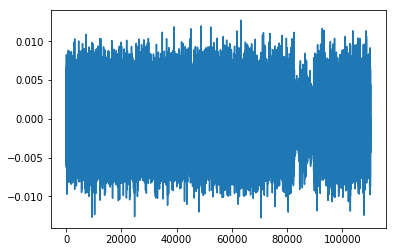

In [22]:
no = np.random.randint(np.shape(roi_lst_)[0])
pltstft = plotstft(colormap="Greys", srr = 22050, sam = roi_lst_[no])
plt.plot(roi_lst_[no])
print(lab_lst_[no])
ipd.Audio(roi_lst_[no], rate= 22050)

(407, 837, 3)
0.7501043083900226 0.8130430839002267 0.8894557823129252 0.804421768707483


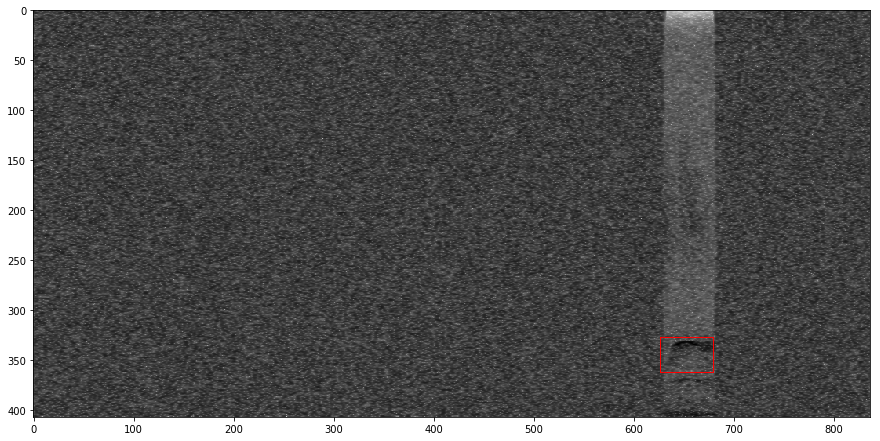

In [23]:
import cv2

img = cv2.imread('test.png')

print(np.shape(img))

x1,x2,y1,y2 = lab_lst_[no]

print(x1,x2,y1,y2)

x1 = int(x1*837)
x2 = int(x2*837)
        
y1 = int(y1*407)
y2 = int(y2*407)
        


cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 1)

plt.figure(figsize=(15,10))

plt.imshow(img)
plt.show()


In [24]:
x1,x2,y1,y2


(627, 680, 362, 327)

(300, 616, 3)
0.7501043083900226 0.8130430839002267 0.8894557823129252 0.804421768707483
462 500 266 241


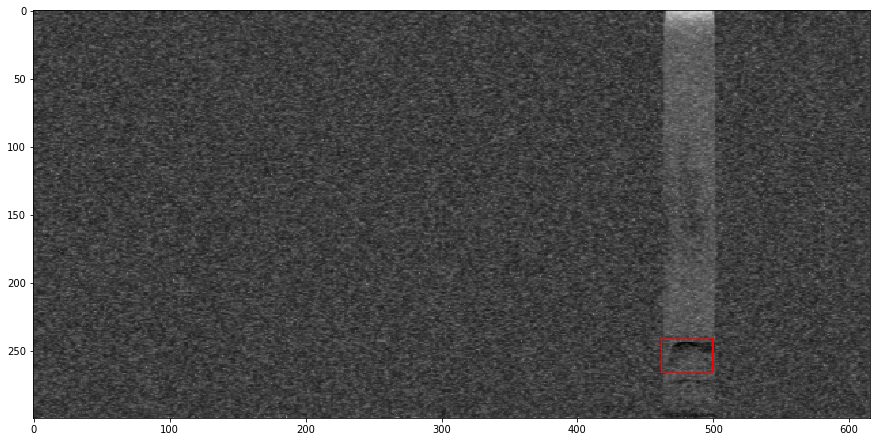

In [26]:
img = cv2.imread('test.png')

resiz_img = cv2.resize(img, (616, 300)) 

print(np.shape(resiz_img))

x1,x2,y1,y2 = lab_lst_[no]
print(x1,x2,y1,y2)

x1 = int(x1*np.shape(resiz_img)[1])
x2 = int(x2*np.shape(resiz_img)[1])
        
y1 = int(y1*np.shape(resiz_img)[0])
y2 = int(y2*np.shape(resiz_img)[0]) 

print(x1,x2,y1,y2)

cv2.rectangle(resiz_img, (x1, y1), (x2, y2), (255,0,0), 1)

plt.figure(figsize=(15,10))
plt.imshow(resiz_img)

plt.show()

In [10]:
x1,x2,y1,y2

(32, 58, 744, 673)

In [11]:
norm = 'l1'
jl_arr_norm = normalize((jl_arr[:][:30])[:,np.newaxis], axis = 1, norm = 'l1')
plt.plot(jl_arr_norm[no])

NameError: name 'jl_arr' is not defined

In [ ]:
aye, nye = 0, 0
for i in range(len(jl_arr)):
    #print(len(jl_arr[i]))
    if (len(jl_arr[i]) < 31000):
        #print("Aye")
        aye +=1
    else:
        nye += 1

print(nye)
print(aye)        

In [ ]:
n = (np.random.normal(0, 0.001, (100,31000)))
n_norm_ = normalize(n, axis=0, norm='l2')

In [ ]:
plt.plot(n_norm_[0])
plt.plot(n[0])
